In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
train_data=MNIST(root='dataset/train/',train=True,download=True,transform=ToTensor())
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/train/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data=MNIST(root='dataset/test/',train=False,download=True,transform=ToTensor())
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset/test/
    Split: Test
    StandardTransform
Transform: ToTensor()

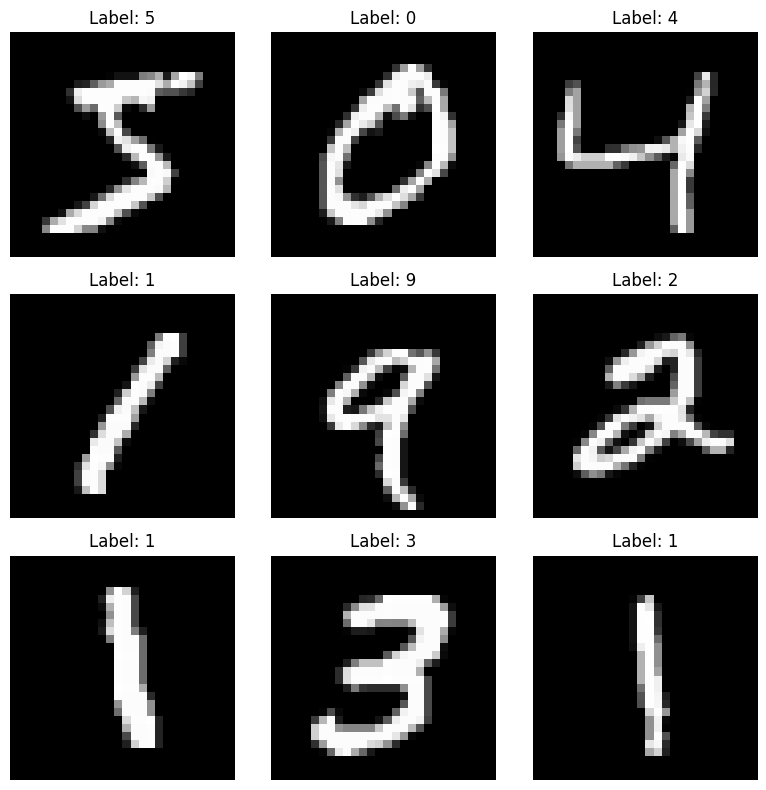

In [4]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

# Plot images
for i in range(3):
    for j in range(3):
        img, label = train_data[i * 3 + j]  # Accessing each image and label
        axs[i, j].imshow(img.squeeze(),cmap='gray')
        axs[i, j].set_title(f'Label: {label}')
        axs[i, j].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [5]:
# train set
X_train=torch.flatten(train_data.data,1,2).to(torch.float32)
Y_train=train_data.targets.reshape(X_train.shape[0],1).to(torch.int8)

X_train.shape,Y_train.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [6]:
# test set
X_test=torch.flatten(test_data.data,1,2).to(torch.float32)

Y_test=test_data.targets.reshape(X_test.shape[0],1).to(torch.int8)

X_test.shape,Y_test.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [7]:
## One hot encoding For the labels

Y_enc_train=torch.zeros((Y_train.shape[0],len(train_data.classes))).to(torch.int8)

for i in range(Y_train.shape[0]):
    Y_enc_train[i][Y_train[i].item()]=1


Y_enc_test=torch.zeros((Y_test.shape[0],len(test_data.classes))).to(torch.int8)

for i in range(Y_test.shape[0]):
    Y_enc_test[i][Y_test[i].item()]=1


Y_enc_train.shape,Y_enc_test.shape

(torch.Size([60000, 10]), torch.Size([10000, 10]))

In [8]:
Y_enc_train.shape

torch.Size([60000, 10])

## Min max scaling of the training and testing data

In [9]:

# scaling train dataset
for i in range(X_train.shape[0]):
    X_train[i]=(X_train[i]-X_train[i].min())/(X_train[i].max()-X_train[i].min())


# scaling test dataset
for i in range(X_test.shape[0]):
    X_test[i]=(X_test[i]-X_test[i].min())/(X_test[i].max()-X_test[i].min())

In [10]:
# Weight and Bias Initialization

# this one is for testing manually computed gradient
w_test=torch.randn((X_train.shape[1],Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=True)
b_test=torch.randn((1,Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=True)


W=torch.randn((X_train.shape[1],Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=False)
b=torch.randn((1,Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=False)

W,b.shape,W.dtype,b

(tensor([[-2.3828, -0.0384, -0.7482,  ...,  0.0242, -0.6050,  0.8592],
         [ 1.0213, -0.4123,  0.5190,  ...,  1.0188, -0.8578, -0.9540],
         [-0.9221,  0.1881,  0.6282,  ...,  0.2566, -2.2773, -0.1368],
         ...,
         [ 0.1366, -0.3608,  1.4731,  ..., -1.2927,  0.3903,  1.2524],
         [-0.3379, -0.9434, -0.5505,  ..., -0.8600, -0.1427, -0.6380],
         [ 0.8305,  0.0942, -0.6904,  ...,  0.0704,  0.9140,  0.3981]]),
 torch.Size([1, 10]),
 torch.float32,
 tensor([[-0.9795,  0.3770, -0.2940,  0.8024, -0.6843,  0.9187,  1.1333,  0.3559,
           0.1754,  1.1980]]))

In [11]:
Z=X_train@w_test+b_test
print(Z.max())

tensor(38.5055, grad_fn=<MaxBackward1>)


In [12]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

In [13]:
def categorical_cross_entropy(Y_enc_train,Y_hat):
    return torch.sum((-Y_enc_train*torch.log(Y_hat)),dim=1,keepdim=True).mean()
 

In [14]:
Y_hat_grad=softmax(Z)
Loss_grad=categorical_cross_entropy(Y_enc_train,Y_hat_grad)
Loss_grad

tensor(14.5432, grad_fn=<MeanBackward0>)

In [15]:
# Calculating Gradients

dL_dZ= (Y_hat_grad-Y_enc_train)/X_train.shape[0]
dZ_dW= X_train

dL_dW=dZ_dW.T@dL_dZ

dL_db=torch.sum(dL_dZ,dim=0,keepdim=True)

print(f"shape- dL_dZ: {dL_dZ.shape}\
      \nshape- dZ_dW: {dZ_dW.shape}\
      \nshape- dL_dW: {dL_dW.shape}\
      \nshape- dL_db: {dL_db.shape}")


shape- dL_dZ: torch.Size([60000, 10])      
shape- dZ_dW: torch.Size([60000, 784])      
shape- dL_dW: torch.Size([784, 10])      
shape- dL_db: torch.Size([1, 10])


## Testing if the manually computed gradient are right

In [16]:
Loss_grad.backward()

print(w_test.grad[600],b_test.grad)
print(f"Weight comparison:{torch.allclose(w_test.grad,dL_dW)}\
  \nBias Comparison: {torch.allclose(b_test.grad,dL_db)}")

tensor([-0.0664, -0.0350, -0.0504, -0.0011,  0.1335, -0.0291, -0.0652,  0.1076,
         0.0308, -0.0247]) tensor([[-0.0932, -0.0752, -0.0927, -0.0059,  0.2232, -0.0609, -0.0913,  0.1731,
          0.1183, -0.0954]])
Weight comparison:True  
Bias Comparison: True


In [17]:
loss_list_train=[]
loss_list_test=[]

## Training Loop

In [21]:
# Training Loop
for i in range(500):
    Z=X_train@W+b

    Y_hat=softmax(Z)
    Loss=categorical_cross_entropy(Y_enc_train,Y_hat)

    loss_list_train.append(Loss.item())

    dL_dZ= (Y_hat-Y_enc_train)/X_train.shape[0]
    dZ_dW= X_train


    dL_dW=dZ_dW.T@dL_dZ
    dL_db=torch.sum(dL_dZ,dim=0,keepdim=True)


    W=W-0.99*dL_dW
    b=b-0.99*dL_db


    Z_test=X_test@W+b
    Y_hat_test=softmax(Z_test)
    Loss_test=torch.sum((-Y_enc_test*torch.log(Y_hat_test)),dim=1,keepdim=True).mean()
    loss_list_test.append(Loss_test.item())



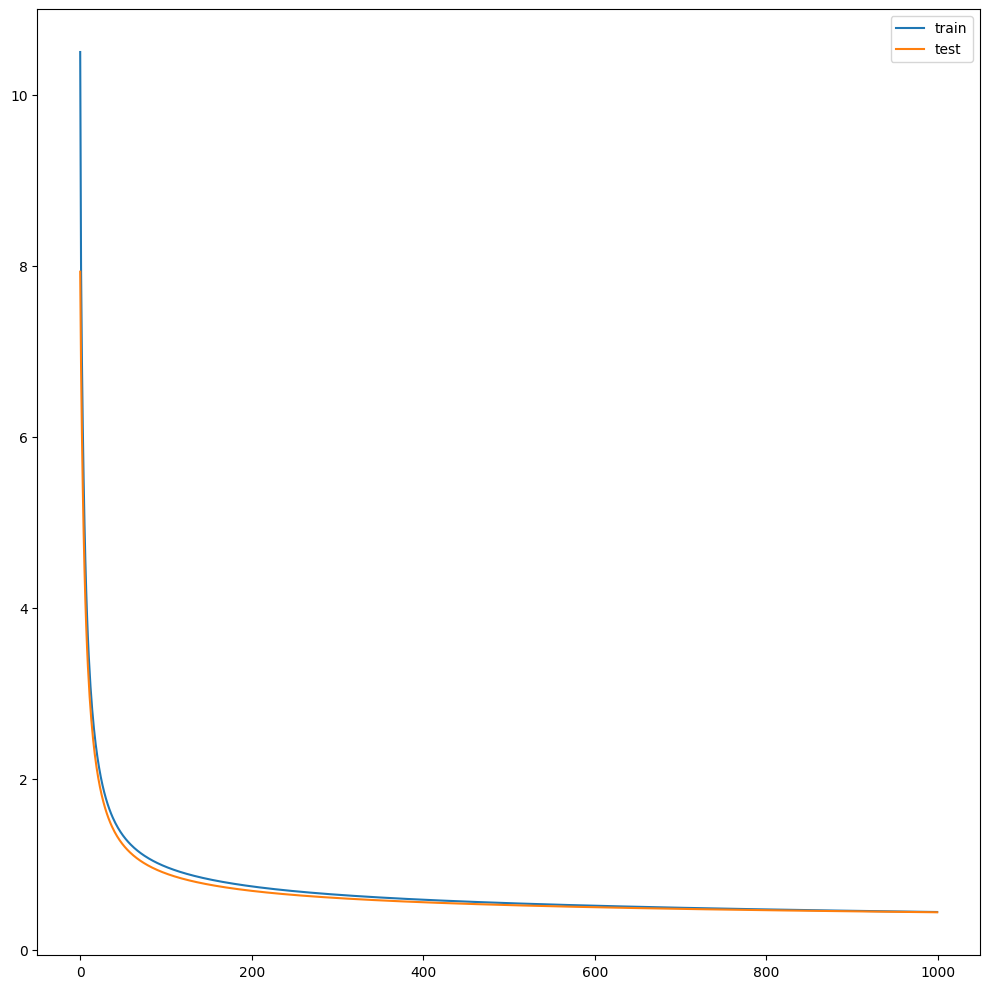

In [22]:
plt.figure(figsize=(10,10))
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.tight_layout()
plt.show()

## Train and Test Accuracy

In [23]:
# train accuracy
y_pred=torch.argmax(Y_hat,dim=1,keepdim=True)
train_acc=torch.sum(Y_train==y_pred)/Y_train.shape[0]


# test accuracy
Z_test=X_test@W+b
Y_hat_test=softmax(Z_test)
y_pred_test=torch.argmax(Y_hat_test,dim=1,keepdim=True)
test_acc=torch.sum(Y_test==y_pred_test)/Y_test.shape[0]

print(f"Train Accuracy: {train_acc}\
      \nTest Accuracy: {test_acc}")


Train Accuracy: 0.8942000269889832      
Test Accuracy: 0.8949999809265137
